In [1]:
from lxml import etree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import cartopy.crs as ccrs
from cartopy.io.img_tiles import MapQuestOpenAerial, MapQuestOSM, OSM
%matplotlib inline

In [2]:
fn = r"activity_721671330.gpx"
tree = etree.parse(fn)
root = tree.getroot()

Find all the `trkpt` elements

In [3]:
string = ".//{http://www.topografix.com/GPX/1/1}"

lon, lat, time = [], [], []
for point in tree.findall(string + "trkpt"):
    lon.append(point.attrib.get("lon"))
    lat.append(point.attrib.get("lat"))
    time.append(point.find(string + "time").text)

In [4]:
lon=np.array(lon).astype('float')
lat=np.array(lat).astype('float')

In [5]:
fmt = '%Y-%m-%dT%H:%M:%S.%fZ'
time = [datetime.strptime(d, fmt) for d in time]

Find all the `hr` elements in the `gpstpx` namespace 

In [6]:
namespace = {'gpxtpx': 'http://www.garmin.com/xmlschemas/TrackPointExtension/v1',
             'gpxx': 'http://www.garmin.com/xmlschemas/GpxExtensions/v3',
             'xsi': 'http://www.w3.org/2001/XMLSchema-instance'
             }
elist = tree.xpath(".//gpxtpx:hr", namespaces=namespace)
hr = [float(e.text) for e in elist]

Make the dataframe

In [7]:
df = pd.DataFrame.from_dict(dict(time=time, lon=lon, lat=lat, hr=hr))
df.set_index('time', drop=True, inplace=True)

In [8]:
df.head(5)

,hr,lat,lon
time,,,
2015-03-16 20:32:31,120,41.579033,-70.531468
2015-03-16 20:32:32,120,41.579034,-70.531459
2015-03-16 20:32:35,117,41.579035,-70.531433
2015-03-16 20:32:42,117,41.579039,-70.531378
2015-03-16 20:32:43,128,41.579041,-70.531372


Plot the heartrate

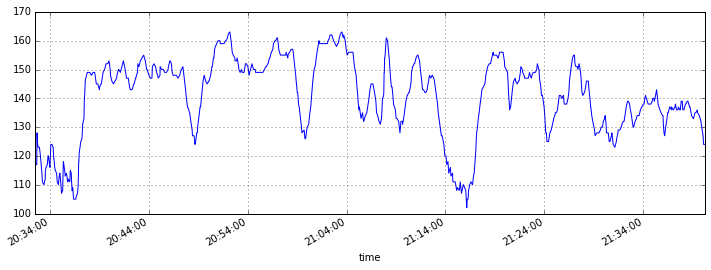

In [9]:
df['hr'].plot(figsize=(12,4));

Plot lon/lat with Cartopy

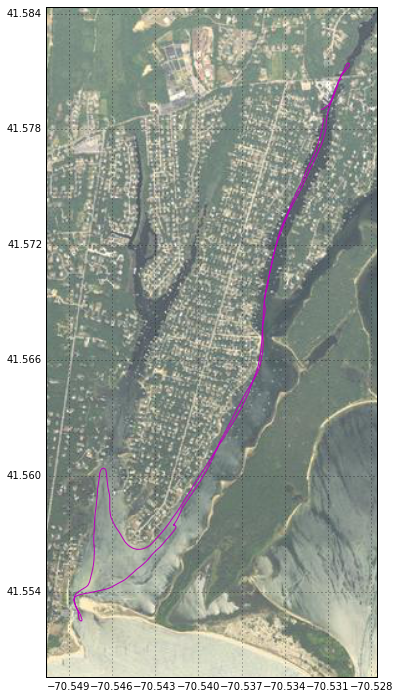

In [10]:
geodetic = ccrs.Geodetic(globe=ccrs.Globe(datum='WGS84'))
b=np.array([lon.min(), lat.min(), lon.max(), lat.max()])

plt.figure(figsize=(12,12))
# Open Source Imagery from MapQuest (max zoom = 16?)
tiler = MapQuestOpenAerial()
# Open Street Map (max zoom = 18?)
#tiler = OSM()
ax = plt.axes(projection=tiler.crs)
dx=b[2]-b[0]
dy=b[3]-b[1]
extent = (b[0]-0.1*dx,b[2]+0.1*dx,b[1]-0.1*dy,b[3]+0.1*dy)
ax.set_extent(extent, geodetic)
ax.add_image(tiler, 14)
plt.plot(lon,lat,'m-',transform=ccrs.PlateCarree());
gl=ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False